In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
from tqdm import tqdm_notebook
import datetime
import gc
from itertools import cycle, islice
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit
import multiprocessing
import warnings
import datetime
from sklearn.preprocessing import LabelEncoder

In [4]:
sns.set()
%matplotlib inline

In [5]:
warnings.simplefilter('ignore')
files = ['./input/test_identity.csv', 
         './input/test_transaction.csv',
         './input/train_identity.csv',
         './input/train_transaction.csv',
         './input/sample_submission.csv']

In [6]:
#可以对数据进行压缩，从而减少内存消耗
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def load_data(file):
    return reduce_mem_usage(pd.read_csv(file))

In [85]:
%%time
# 线程池读取多个数据集
with multiprocessing.Pool() as pool:
    test_identity, test_transaction, train_identity, train_transaction, sample_submission = pool.map(load_data,files)

Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
CPU times: user 1.33 s, sys: 1.6 s, total: 2.93 s
Wall time: 2min 29s


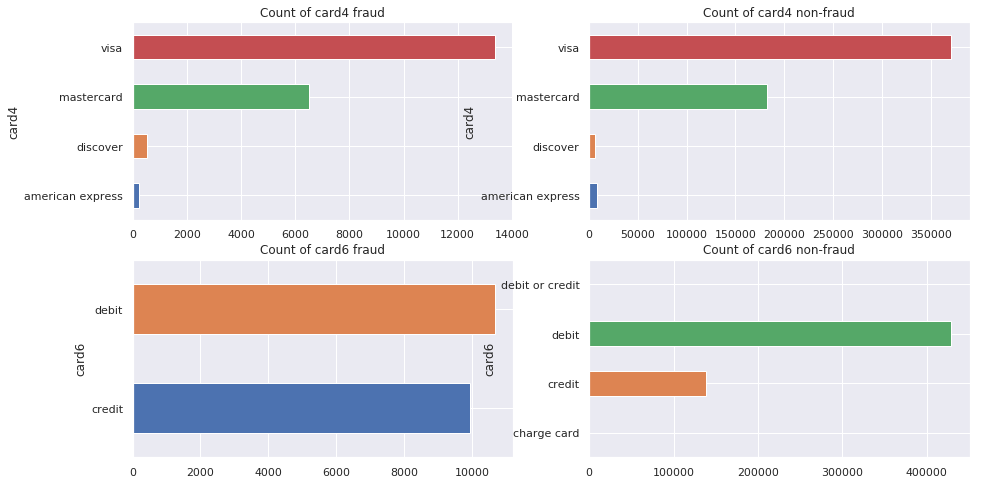

In [90]:
#根绝y值不同来看x某个特征的分布
train_transaction_fr = train_transaction.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = train_transaction.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

In [206]:
#合并数据
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [9]:
print ("% of train_transaction data missing = ",(train_transaction[train_transaction.columns].isnull().sum().sum()/np.product(train_transaction.shape)) * 100)
print ("% of train_identity data missing = ",(train_identity[train_identity.columns].isnull().sum().sum()/np.product(train_identity.shape)) * 100)
print ("% of test_transaction data missing = ",(test_transaction[test_transaction.columns].isnull().sum().sum()/np.product(test_transaction.shape)) * 100)
print ("% of test_identity data missing = ",(test_identity[test_identity.columns].isnull().sum().sum()/np.product(test_identity.shape)) * 100)
print ("% of train data missing = ",(train[train.columns].isnull().sum().sum()/np.product(train.shape)) * 100)
print ("% of test data missing = ",(test[test.columns].isnull().sum().sum()/np.product(test.shape)) * 100)

% of train_transaction data missing =  41.073431200111266
% of train_identity data missing =  35.58109650830896
% of test_transaction data missing =  36.90570194240822
% of test_identity data missing =  36.18627245910109
% of train data missing =  45.074371905803936
% of test data missing =  41.10668083585368


In [10]:
print("len(train):'{}',len(test):'{}'".format(len(train),len(test)))

len(train):'590540',len(test):'506691'


In [11]:
train.columns.values

array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V6

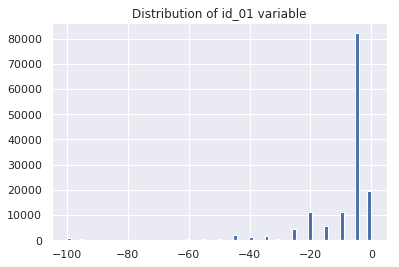

In [12]:
plt.hist(train['id_01'], bins=77);
plt.title('Distribution of id_01 variable');
#非正值 在0附近更多？？？

In [13]:
train['id_03'].value_counts(dropna=False, normalize=True).head()
#id_03  88%的缺失值   缺失值或者值为0占了98%

NaN     0.887689
 0.0    0.108211
 1.0    0.001461
 3.0    0.001131
 2.0    0.000713
Name: id_03, dtype: float64

In [14]:
train['id_11'].value_counts(dropna=False, normalize=True).head()
#同样奇怪 

NaN          0.761273
 100.0000    0.225492
 95.0625     0.002112
 95.1875     0.001360
 97.1250     0.000957
Name: id_11, dtype: float64

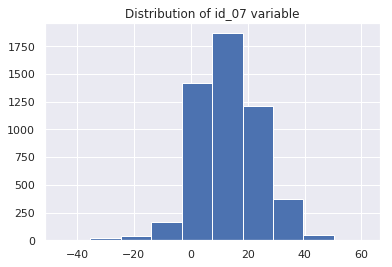

In [15]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');
#标准化的正态分布 所以想统一处理一批数据变标准化 必须把这些之前已经正态化的数据提出

In [16]:
train['id_12'].value_counts(dropna=False, normalize=True).head() #id_15,id_28,id_29,id_34,id_35.id_37,id_38

NaN         0.755761
NotFound    0.208326
Found       0.035913
Name: id_12, dtype: float64

In [17]:
train['id_30'].value_counts(dropna=False, normalize=True).head()

NaN           0.868654
Windows 10    0.035823
Windows 7     0.022200
iOS 11.2.1    0.006303
iOS 11.1.2    0.006264
Name: id_30, dtype: float64

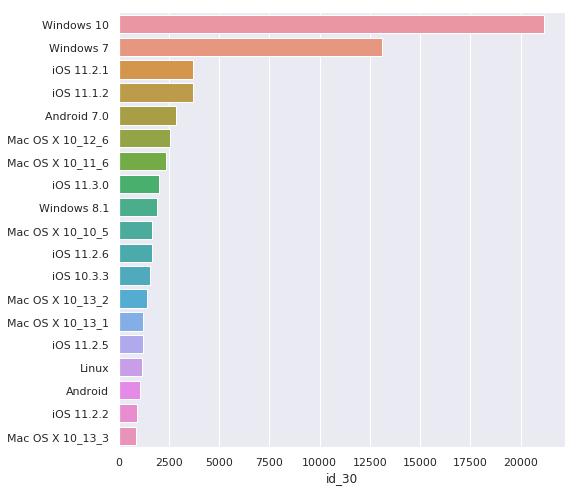

In [18]:
plt.figure(figsize=(8, 8))
sns.barplot(train["id_30"].value_counts(dropna=False)[:20],
            train["id_30"].value_counts(dropna=False).keys()[:20])
plt.show()

In [19]:
train['id_31'].value_counts(dropna=False, normalize=True).head()

NaN                      0.762451
chrome 63.0              0.037254
mobile safari 11.0       0.022730
mobile safari generic    0.019430
ie 11.0 for desktop      0.015291
Name: id_31, dtype: float64

In [20]:
train['id_33'].value_counts(dropna=False, normalize=True).head()

NaN          0.875895
1920x1080    0.028574
1366x768     0.014571
1334x750     0.010917
2208x1242    0.008297
Name: id_33, dtype: float64

In [21]:
train['DeviceInfo'].value_counts(dropna=False, normalize=True).head()

NaN            0.799055
Windows        0.080811
iOS Device     0.033498
MacOS          0.021291
Trident/7.0    0.012599
Name: DeviceInfo, dtype: float64

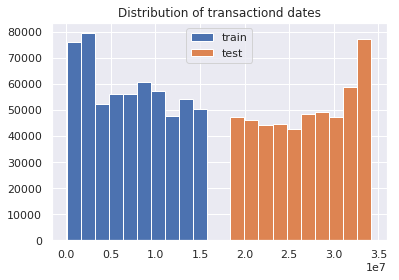

In [82]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');
#train 和 test 的TransactionDT 日期没有重叠 所以使用基于时间的分割进行验证是明智的

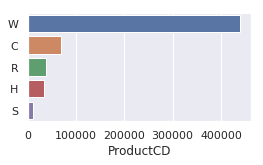

In [89]:
plt.figure(figsize=(4, 2))
sns.barplot(train["ProductCD"].value_counts(dropna=False)[:20],
            train["ProductCD"].value_counts(dropna=False).keys()[:20])
plt.show()

Text(0, 0.5, 'Count')

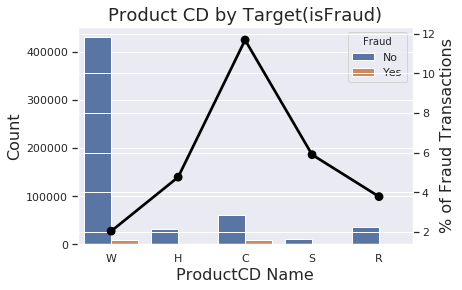

In [72]:
tmp = pd.crosstab(train_transaction['ProductCD'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(6, 4))
plot_2 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)

plot_2.set_title("Product CD by Target(isFraud)", fontsize=18)
plot_2.set_xlabel("ProductCD Name", fontsize=16)
plot_2.set_ylabel("Count", fontsize=16)

In [65]:
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

In [67]:
#train.groupby(['card1'])['D15'].transform('mean')
#train +test 组合以后看value值的count个数 然后对train[card3] 整个字断根据value值赋给之前得到的相应的count值
train['card3_count_full'] = train['card3'].map(pd.concat([train['card3'], test['card3']], ignore_index=True).value_counts(dropna=False))

In [91]:
train["card6"].value_counts(dropna=False)[:20]
#卡的类型

debit              439938
credit             148986
NaN                  1571
debit or credit        30
charge card            15
Name: card6, dtype: int64

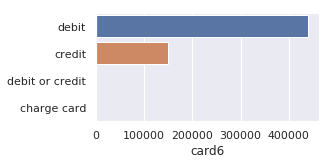

In [90]:
plt.figure(figsize=(4, 2))
sns.barplot(train["card6"].value_counts(dropna=False)[:20],
            train["card6"].value_counts(dropna=False).keys()[:20])
plt.show()

In [92]:
train["card4"].value_counts(dropna=False)[:20]
#信用卡公司

visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: card4, dtype: int64

In [309]:
#train['TransactionDT']

In [305]:
train['C4'].value_counts()

0.0       451883
1.0       111817
2.0        12994
3.0         4949
4.0         1902
5.0          851
6.0          597
7.0          372
9.0          273
10.0         233
8.0          226
12.0         175
11.0         167
16.0         116
15.0         116
17.0         113
13.0         109
14.0          91
20.0          81
18.0          71
52.0          63
21.0          60
19.0          58
30.0          49
83.0          43
24.0          41
70.0          40
51.0          39
91.0          35
39.0          35
           ...  
1010.0         1
1792.0         1
252.0          1
1007.0         1
2016.0         1
1733.0         1
1030.0         1
258.0          1
1725.0         1
1715.0         1
1059.0         1
1058.0         1
1057.0         1
429.0          1
1717.0         1
430.0          1
431.0          1
1051.0         1
1049.0         1
259.0          1
1726.0         1
1730.0         1
1045.0         1
1908.0         1
1042.0         1
288.0          1
260.0          1
433.0         

In [301]:
train["M2"].value_counts(dropna=False)[:]

T      285468
NaN    271100
F       33972
Name: M2, dtype: int64

In [97]:
train["M3"].value_counts(dropna=False)[:]#M系列都是如此

NaN    271100
T      251731
F       67709
Name: M3, dtype: int64

In [175]:
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

def getx(x):
    if x=='T':
        return 1
    elif x=='F':
        return 0
    
for df in [train, test]:
    aa = df[i_cols].applymap(getx)
    df['M_sum'] = aa.sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [181]:
train['V1'].value_counts(dropna=False)[:]

 1.0    311236
NaN     279287
 0.0        17
Name: V1, dtype: int64

In [99]:
train["P_emaildomain"].value_counts(dropna=False)[:10]
#邮箱

gmail.com        228355
yahoo.com        100934
NaN               94456
hotmail.com       45250
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
Name: P_emaildomain, dtype: int64

In [23]:
train["R_emaildomain"].value_counts(dropna=False)[:10]
#为啥有两个字段 切后一个有很多空值呢?

NaN              453249
gmail.com         57147
hotmail.com       27509
anonymous.com     20529
yahoo.com         11842
aol.com            3701
outlook.com        2507
comcast.net        1812
yahoo.com.mx       1508
icloud.com         1398
Name: R_emaildomain, dtype: int64

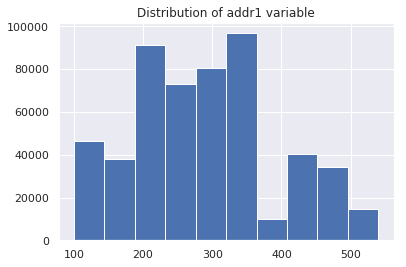

In [28]:
# 'addr1', 'addr2', 'dist1', 'dist2',
plt.hist(train['addr1']);
plt.title('Distribution of addr1 variable');

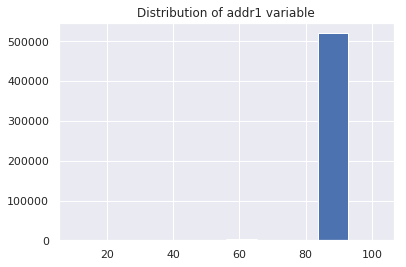

In [29]:
plt.hist(train['addr2']);
plt.title('Distribution of addr1 variable');

In [44]:
train['addr2'].value_counts(dropna=False)[:10]

 87.0     520481
NaN        65706
 60.0       3084
 96.0        638
 32.0         91
 65.0         82
 16.0         55
 31.0         47
 19.0         33
 26.0         25
 27.0         20
 59.0         17
 69.0         17
 34.0         16
 43.0         12
 102.0        11
 29.0         11
 98.0         11
 68.0         10
 57.0         10
 78.0          8
 10.0          8
Name: addr2, dtype: int64

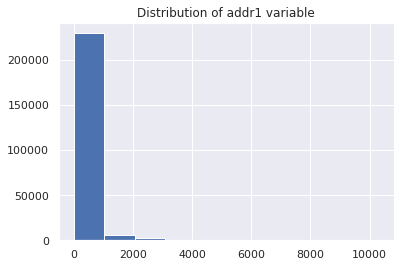

In [45]:
plt.hist(train['dist1']);
plt.title('Distribution of addr1 variable');

In [190]:
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']
#统计M1-M9共有多少个T
def getx(x):
    if x=='T':
        return 1
    elif x=='F':
        return 0
    
aa = train[i_cols].applymap(getx)

In [192]:
aa.drop(['M1','M2'],axis=1, inplace=True)

In [196]:
import featuretools as ft

In [197]:
data = ft.demo.load_mock_customer()

In [201]:
customers_df = data["customers"]
sessions_df = data["sessions"]
transactions_df = data["transactions"]

In [204]:
transactions_df

,transaction_id,session_id,transaction_time,product_id,amount
0,298,1,2014-01-01 00:00:00,5,127.64
1,2,1,2014-01-01 00:01:05,2,109.48
2,308,1,2014-01-01 00:02:10,3,95.06
3,116,1,2014-01-01 00:03:15,4,78.92
4,371,1,2014-01-01 00:04:20,3,31.54
5,486,1,2014-01-01 00:05:25,3,23.76
6,271,1,2014-01-01 00:06:30,3,43.63
7,192,1,2014-01-01 00:07:35,4,42.27
8,341,1,2014-01-01 00:08:40,3,47.68
9,10,1,2014-01-01 00:09:45,5,57.39


In [46]:
train['dist1'].value_counts(dropna=False)[:10]

NaN      352271
 0.0      19824
 1.0      18330
 2.0      17028
 4.0      13067
 3.0      12808
 5.0      12004
 6.0       9843
 7.0       9340
 8.0       7731
 9.0       7728
 10.0      6288
Name: dist1, dtype: int64

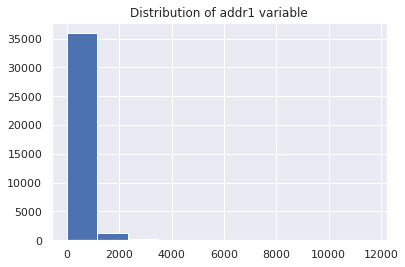

In [47]:
plt.hist(train['dist2']);
plt.title('Distribution of addr1 variable');

In [48]:
train['dist2'].value_counts(dropna=False)[:10]

NaN       552913
 7.0        5687
 0.0        3519
 1.0        1374
 9.0         742
 4.0         659
 2.0         556
 3.0         490
 68.0        485
 6.0         412
 13.0        397
 199.0       362
 10.0        356
Name: dist2, dtype: int64

In [ ]:
##dist1 dist2 代表什么呢

In [78]:
train['id_34'].value_counts()

match_status:2     60011
match_status:1     17376
match_status:0       415
match_status:-1        3
Name: id_34, dtype: int64

In [189]:
test['V111'].value_counts()

1.0    504886
2.0      1566
3.0       180
4.0        38
5.0        11
6.0         3
0.0         3
7.0         2
8.0         2
Name: V111, dtype: int64

In [32]:
#转化成时间格式
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

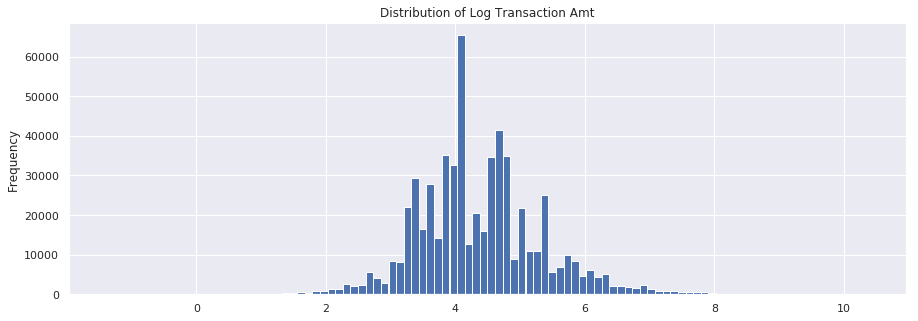

In [45]:
train['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

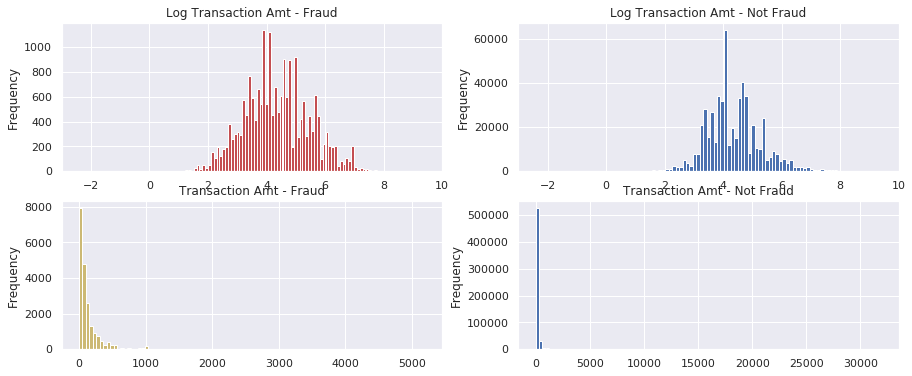

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color='r',
          xlim=(-3, 10),
         ax= ax1)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color='b',
          xlim=(-3, 10),
         ax=ax2)
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color='y',
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color='b',
         ax=ax4)
plt.show()

In [207]:
#计算card1 woe值
train["card1"].value_counts(dropna=False)[:20]

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
12695     7091
12544     6773
6019      6771
2803      6141
7585      5334
10616     5172
12839     5129
3154      4614
2616      4410
18132     4209
9633      4158
15497     3977
16132     3929
2884      3873
16075     3748
Name: card1, dtype: int64

In [209]:
aa = train[['isFraud','card1']]

In [213]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

In [285]:
table = pd.crosstab(train['isFraud'],train['card1'])
#相当于对card1的值进行分箱了 每个箱子中好坏的个数

In [287]:
#计算比率
ratio_table = table.div(table.sum(axis=1),axis=0)

In [288]:
woe_table = table.div(table.sum(axis=1),axis=0)

In [291]:
woe_table

card1,1000,1001,1004,1005,1006,1007,1008,1009,1010,1011,...,18383,18384,18385,18387,18388,18390,18391,18393,18395,18396
isFraud,,,,,,,,,,,,,,,,,,,,,
0,0.000002,0.000005,0.000009,0.000002,0.000005,0.000004,0.000005,0.000009,0.000002,0.000004,...,0.000012,0.000018,0.00007,0.000011,0.000002,0.000112,0.000002,0.000005,0.000019,0.000002
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [282]:
#woe=ratio_table.iloc[1,:]/ratio_table.iloc[0,:]

In [294]:
#计算各个分箱的woe值
woe=(woe_table.iloc[1,:]/woe_table.iloc[0,:]).apply(lambda x:np.log(x))